In [35]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv
import pandas as pd
import os
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')


In [2]:
files_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/knowledge-distillation/autoencoders/output/'
input_file = files_dir + 'l1_ae_train_loss.h5'


In [3]:
with h5py.File(input_file,'r') as open_file :
    train_data = np.array(open_file['data'])
idx_jet_0,idx_jet_1=9,19


In [4]:
events_with_jets_mask = np.where(train_data[:,idx_jet_0,0,0]!=0)

In [5]:
particles_in_jet = np.squeeze(train_data[events_with_jets_mask][:,idx_jet_0:,:,:],axis=-1)

In [115]:
jet_dir = 'JES_corrections/'
jet_pt_bins = [30,60,110,400]
jet_file_names = ['jets_eta_for_%dGeV_jets.csv'%jet_bin for jet_bin in jet_pt_bins]
jes_correction_data = {}
for i,jet_bin in enumerate(jet_pt_bins) :
    jes_correction_data[jet_bin] = pd.read_csv(jet_dir+jet_file_names[i], names=['eta','jet_response'])

#create_unique bin centers for all jet pt bins
bin_edges = np.linspace(0,4.8,49)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
for i,jet_bin in enumerate(jet_pt_bins) :
    jes_correction_data[jet_bin]['abs_eta_bin_centers'] = bin_centers
    
for i,jet_bin in enumerate(jet_pt_bins) :    
    jes_correction_data[jet_bin].to_csv(jet_dir+jet_file_names[i].replace('.csv','_updated.csv'))      
    

In [169]:
#create a multidimensional array from the dataframe
jes_correction_data_array = []
for i,jet_bin in enumerate(jet_pt_bins) :
    jes_correction_data_array.append(jes_correction_data[jet_bin][['abs_eta_bin_centers','jet_response']].values)
jes_correction_data_array = np.stack(jes_correction_data_array, axis=0)

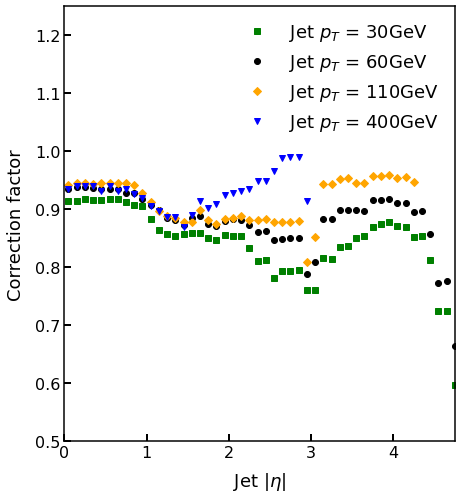

In [229]:
matplotlib.rcParams.update({'font.size': 18})
markers=['s', 'o', 'D', 'v']
colors=['g','black','orange','b']
for i,jet_bin in enumerate(jet_pt_bins) :
    _ = plt.plot(jes_correction_data[jet_bin]['abs_eta_bin_centers'],jes_correction_data[jet_bin]['jet_response'], label='Jet $p_T$ = %dGeV'%jet_bin,
                linestyle = 'None',
                marker=markers[i],
                color=colors[i])
plt.legend()
plt.ylabel('Correction factor')
plt.xlabel('Jet |$\eta$|')
plt.xlim(0, 4.75)
plt.ylim(0.5, 1.25)
plt.show()


In [216]:
def apply_correction(jes_correction_data_array,jet_pt_bins,sample,jet_pt_idx=0,jet_eta_idx=1):
    jet_eta_bins = jes_correction_data_array[0,:,0]
    
    indecies_pt = np.searchsorted(jet_pt_bins, abs(sample[:,:,jet_pt_idx]),side='left')
    indecies_pt = np.where(indecies_pt==len(jet_pt_bins),len(jet_pt_bins)-1,indecies_pt)

    indecies_eta = np.searchsorted(jet_eta_bins, abs(sample[:,:,jet_eta_idx]),side='left')
    indecies_eta = np.where(indecies_eta==len(jes_correction_data[jet_bin]['eta']),len(jes_correction_data[jet_bin]['eta'])-1,indecies_eta)
    
    return indecies_pt,indecies_eta


In [217]:
indecies_pt,indecies_eta = apply_correction(jes_correction_data_array,jet_pt_bins,particles_in_jet)

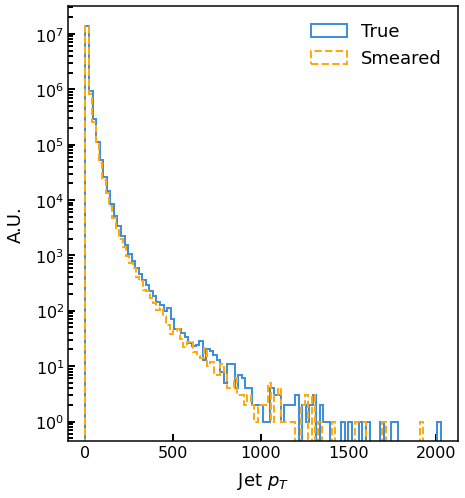

In [233]:
particles_in_jet_smeared = particles_in_jet[:,:,0]*jet_pt_correction
_ = plt.hist(particles_in_jet[:,:,0].reshape(-1),bins=100,histtype='step',linewidth=2,label='True')
_ = plt.hist(particles_in_jet_smeared.reshape(-1),bins=100,histtype='step',linestyle='--',linewidth=2,label='Smeared')
plt.semilogy()
plt.xlabel('Jet $p_T$')
plt.ylabel('A.U.')
plt.legend()


Text(0, 0.5, 'A.U.')

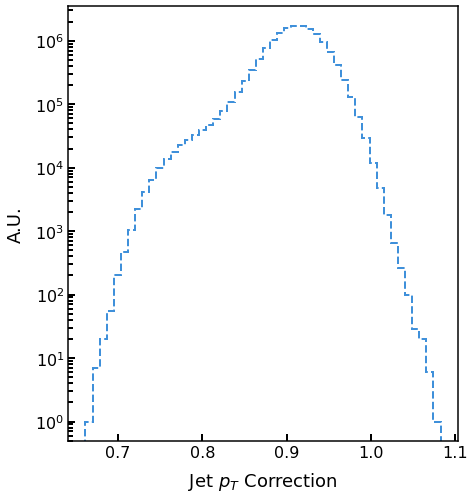

In [234]:
_ = plt.hist(jet_pt_correction.reshape(-1),bins=50,histtype='step',linestyle='--',linewidth=2,label='')
plt.semilogy()
plt.xlabel('Jet $p_T$ Correction')
plt.ylabel('A.U.')



In [237]:
jer_eta_bins = ['0p5','3p2_4']
jer_file_names = ['JER_eta_%s.csv'%jet_bin for jet_bin in jer_eta_bins]
jer_correction_data = {}
for i,jet_bin in enumerate(jer_eta_bins) :
    jer_correction_data[jet_bin] = pd.read_csv(jet_dir+jer_file_names[i], names=['pt','jer'])


In [315]:
def fit_function(x, a, b,c):
    return np.where(x!=0,np.sqrt(a/np.power(x,2)+b/x+c),0.)

do_fit = False
popts, pcovs = [],[]
for i,jet_bin in enumerate(jer_eta_bins) :
    if do_fit:
        popt, pcov = curve_fit(fit_function, xdata=jer_correction_data[jet_bin]['pt'], ydata=jer_correction_data[jet_bin]['jer'])
        popts.append(popt)
        pcovs.append(pcov)
        with open(jet_dir+'fit_result_'+jer_file_names[i].replace('.csv','.npy'), 'wb') as f:
            np.save(f, popts[i])
            np.save(f, pcovs[i])    
    else:    
        with open(jet_dir+'fit_result_'+jer_file_names[i].replace('.csv','.npy'), 'rb') as f:
            popt = np.load(f)
            pcov = np.load(f)   
            popts.append(popt)
            pcovs.append(pcov)


/afs/cern.ch/work/n/nchernya/miniconda3/envs/knowledge_dist/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


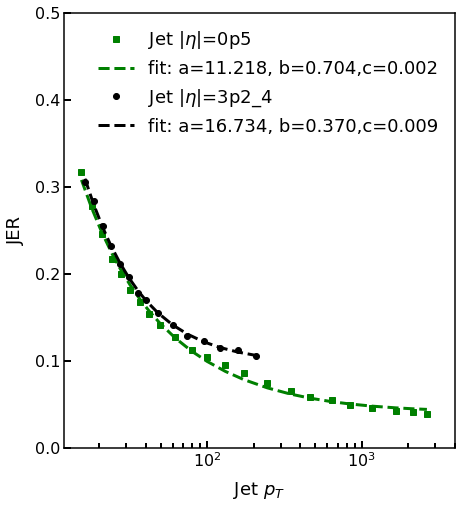

In [316]:
matplotlib.rcParams.update({'font.size': 18})
for i,jet_bin in enumerate(jer_eta_bins) :
    _ = plt.plot(jer_correction_data[jet_bin]['pt'],jer_correction_data[jet_bin]['jer'], label='Jet |$\eta$|=%s'%jet_bin,
                linestyle = 'None',marker=markers[i],color=colors[i])
    plt.plot(jer_correction_data[jet_bin]['pt'], fit_function(jer_correction_data[jet_bin]['pt'], *popts[i]),linewidth=3,
                      linestyle='--',color=colors[i],label='fit: a=%5.3f, b=%5.3f,c=%5.3f' % tuple(popts[i]))


plt.legend()
plt.ylabel('JER')
plt.xlabel('Jet $p_T$')
plt.semilogx()
plt.xlim(0., 4000)
plt.ylim(0., 0.5)
plt.show()

In [317]:
def get_jer(pt,eta,params,eta_bin=3.2):
    return np.where(eta<eta_bin,fit_function(pt, *params[0]),fit_function(pt, *params[1]))

In [318]:
a =  get_jer(particles_in_jet[:,:,0],particles_in_jet[:,:,1],popts)

/afs/cern.ch/work/n/nchernya/miniconda3/envs/knowledge_dist/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [319]:
a

array([[0.23692787, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28629816, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.13278694, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.16815247, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19476974, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1756762 , 0.18879971, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [320]:
jet_pt_jes_jer_factor = jes_correction_data_array[indecies_pt,indecies_eta,1]*np.random.normal(1.0, scale=a, size=jet_pt_correction.shape)





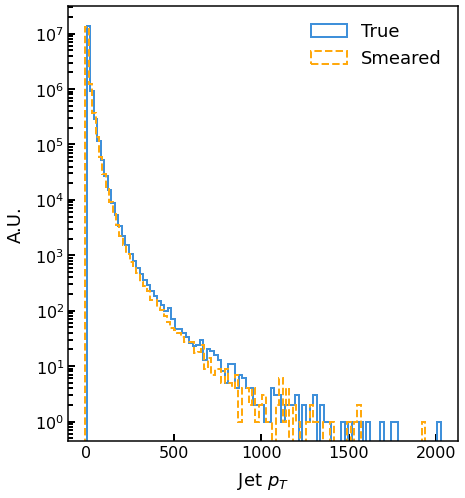

In [322]:
particles_in_jet_smeared = particles_in_jet[:,:,0]*jet_pt_jes_jer_factor
_ = plt.hist(particles_in_jet[:,:,0].reshape(-1),bins=100,histtype='step',linewidth=2,label='True')
_ = plt.hist(particles_in_jet_smeared.reshape(-1),bins=100,histtype='step',linestyle='--',linewidth=2,label='Smeared')
plt.semilogy()
plt.xlabel('Jet $p_T$')
plt.ylabel('A.U.')
plt.legend()

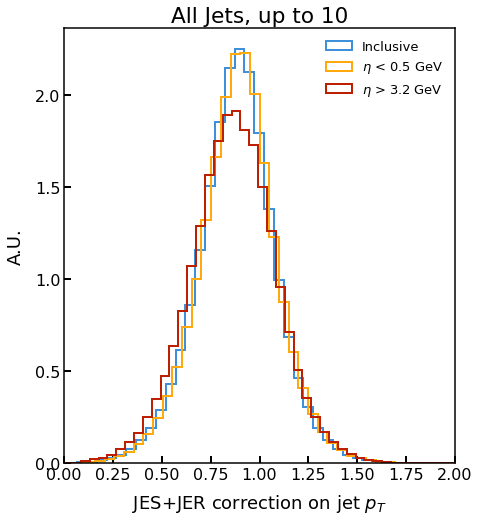

In [362]:
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where(particles_in_jet[:,:,0]>0)],bins=50,histtype='step',density=True,linewidth=2,label='Inclusive')
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where((particles_in_jet[:,:,1]<0.5)&(particles_in_jet[:,:,0]>0))],bins=50,histtype='step',density=True,linewidth=2,label='$\eta$ < 0.5 GeV')
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where((particles_in_jet[:,:,1]>3.2)&(particles_in_jet[:,:,0]>0))],bins=50,histtype='step',density=True,linewidth=2,label='$\eta$ > 3.2 GeV')
plt.title('All Jets, up to 10')
plt.xlim(0, 2)
plt.xlabel('JES+JER correction on jet $p_{T}$')
plt.ylabel('A.U.')
plt.legend(loc='upper right',fontsize=13)


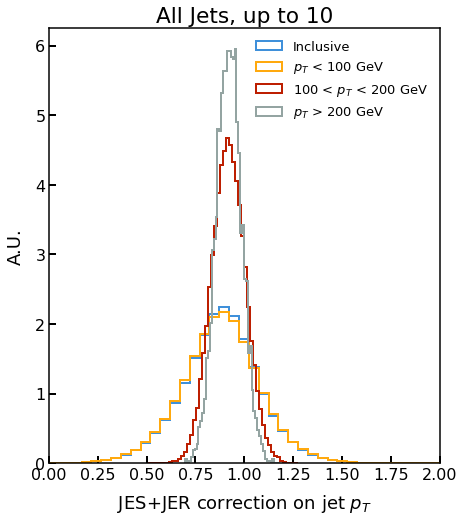

In [360]:
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where(particles_in_jet[:,:,0]>0)],bins=50,histtype='step',density=True,linewidth=2,label='Inclusive')
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where((particles_in_jet[:,:,0]<100)&(particles_in_jet[:,:,0]>0))],bins=50,histtype='step',density=True,linewidth=2,label='$p_{T}$ < 100 GeV')
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where((particles_in_jet[:,:,0]>100) & (particles_in_jet[:,:,0]<200))],bins=50,histtype='step',density=True,linewidth=2,label='100 < $p_{T}$ < 200 GeV')
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where(particles_in_jet[:,:,0]>200)],bins=50,histtype='step',density=True,linewidth=2,label='$p_{T}$ > 200 GeV')
plt.title('All Jets, up to 10')
plt.xlim(0, 2)
plt.xlabel('JES+JER correction on jet $p_{T}$')
plt.ylabel('A.U.')
plt.legend(loc='upper right',fontsize=13)